In [120]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from torch.utils.data import DataLoader, Subset, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import ViTForImageClassification
from torch.amp import autocast, GradScaler
from PIL import Image
import random

In [52]:
from google.colab import drive

In [53]:
os.environ["WANDB_DISABLED"] = "true"

In [54]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
#!cp -r /content/drive/MyDrive/Tesi/data_for_model/six_classes /content/

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True

In [57]:
train_dir = "/content/six_classes/train"
test_dir = "/content/six_classes/test"

In [58]:
def get_augmentation_transform():
    return transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])


In [59]:
transform_test = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
     ])

In [60]:
# ✅ Load dataset class frequencies
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

min_class_count = min(class_counts.values())
print("Class Distribution:", class_counts)
print(f"Balanced Class Count: {min_class_count}")

Class Distribution: {'class_36': 156, 'class_12': 112, 'class_26': 66, 'class_10': 67, 'class_5': 88, 'class_1': 3602}
Balanced Class Count: 66


In [61]:
# ✅ Downsample Majority Class (class_1)
downsampled_class_1 = 1800  # Reduce class_1 to 500 samples to prevent imbalance
class_counts['class_1'] = downsampled_class_1

In [62]:
# ✅ Adjust Augmentation Factor Based on Class Frequency
max_class_count = max(class_counts.values())
print(max_class_count)
aug_factors = {class_name: max(1, max_class_count // count) for class_name, count in class_counts.items()}
aug_factors = {'class_36': 6, 'class_12': 8, 'class_26': 15, 'class_10': 14, 'class_5': 11, 'class_1': 1}
print("Augmentation Factors:", aug_factors)

1800
Augmentation Factors: {'class_36': 6, 'class_12': 8, 'class_26': 15, 'class_10': 14, 'class_5': 11, 'class_1': 1}


In [63]:
aug_factors = {'class_36': 3, 'class_12': 3, 'class_26': 3, 'class_10': 3, 'class_5': 3, 'class_1': 1}

In [64]:
# ✅ Balanced Dataset with Augmentation
#class_labels = {class_name: idx for idx, class_name in enumerate(class_counts.keys())}

In [91]:
class_labels = {'class_36': 4,
 'class_12': 2,
 'class_26': 3,
 'class_10': 1,
 'class_5': 5,
 'class_1': 0}

In [92]:
class AugmentedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []

        for class_name, label in class_labels.items():
            class_dir = os.path.join(root_dir, class_name)
            images = os.listdir(class_dir)

            if class_name == 'class_1':
                images = random.sample(images, downsampled_class_1)  # Downsample majority class

            aug_factor = aug_factors[class_name]
            for img_name in images:
                for _ in range(aug_factor):  # Apply higher augmentation for smaller classes
                    self.samples.append((os.path.join(class_dir, img_name), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        img_path, label = self.samples[index]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label)

In [93]:
# ✅ Create Train and Test Datasets
train_dataset = AugmentedDataset(root_dir=train_dir, transform=get_augmentation_transform())
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_test)

In [94]:
print(Counter([x[1] for x in train_dataset.samples]))
print(Counter([x[1] for x in test_dataset.samples]))
print(set([label.item() for _, label in train_dataset]))
print(set([label for _, label in test_dataset]))

Counter({0: 1800, 4: 468, 2: 336, 5: 264, 1: 201, 3: 198})
Counter({0: 901, 4: 40, 2: 28, 5: 23, 1: 17, 3: 17})
{0, 1, 2, 3, 4, 5}
{0, 1, 2, 3, 4, 5}


In [106]:
468/201, 40/17

(2.328358208955224, 2.3529411764705883)

In [97]:
# # ✅ Split Test Dataset into Validation & Test
# val_ratio = 0.2
# test_indices = list(range(len(test_dataset)))
# val_indices, test_indices = train_test_split(test_indices, test_size=(1 - val_ratio), random_state=42)

# val_dataset = Subset(test_dataset, val_indices)
# test_dataset = Subset(test_dataset, test_indices)

In [98]:
#dataset = datasets.ImageFolder(root="/content/six_classes", transform=get_augmentation_transform())

# Split into train/test
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Use same dataset for consistent class mapping
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [99]:
# ✅ Print Dataset Sizes
print(f"Train Set Size: {len(train_dataset)}")
#print(f"Validation Set Size: {len(val_dataset)}")
print(f"Test Set Size: {len(test_dataset)}")

Train Set Size: 3267
Test Set Size: 1026


In [72]:
train_loader

('/content/six_classes/train/class_36/151460006999.png', 0)

In [74]:
print(Counter([x[1] for x in train_loader.dataset.samples]))
print(Counter([x[1] for x in test_loader.dataset.samples]))
#print(set([label.item() for _, label in train_dataset]))
#print(set([label for _, label in test_dataset]))

Counter({5: 1800, 0: 468, 1: 336, 4: 264, 3: 201, 2: 198})
Counter({0: 901, 4: 40, 2: 28, 5: 23, 1: 17, 3: 17})


In [107]:
# ✅ Compute Class Weights
class_weights = torch.tensor([max_class_count / count for count in class_counts.values()], dtype=torch.float32).to(device)
print("Class Weights:", class_weights)

Class Weights: tensor([11.5385, 16.0714, 27.2727, 26.8657, 20.4545,  1.0000], device='cuda:0')


In [108]:
model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", num_labels=6, ignore_mismatched_sizes=True
)
model.to(memory_format=torch.channels_last).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([6]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([6, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [109]:
# ✅ Freeze Layers Except Last 2 Blocks + Classifier
for name, param in model.named_parameters():
    if "classifier" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [110]:
def count_trainable_parameters(model):
    """Counts and prints the number of trainable parameters in the model."""
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"✅ Total Trainable Parameters: {trainable_params:,}")

# ✅ Example usage
count_trainable_parameters(model)

✅ Total Trainable Parameters: 4,614


In [111]:
# ✅ Loss Function & Optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
scaler = GradScaler()

<ipython-input-111-03cd1629c9fd>:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [112]:
# ✅ Enable Mixed Precision Training
scaler = GradScaler()


<ipython-input-112-6541da8a7e5f>:2: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [116]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

scaler = GradScaler()

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10, patience=5):
    best_val_loss = float("inf")
    early_stop_counter = 0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            with autocast():
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = outputs.logits.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        epoch_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
        epoch_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
        epoch_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

        print(f"Epoch {epoch+1} Train: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%, Precision={epoch_precision:.4f}, Recall={epoch_recall:.4f}, F1-score={epoch_f1:.4f}")

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs.logits, labels)

                val_loss += loss.item()
                _, predicted = outputs.logits.max(1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                val_preds.extend(predicted.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        val_epoch_loss = val_loss / len(val_loader)
        val_epoch_acc = 100 * correct / total
        val_epoch_precision = precision_score(val_labels, val_preds, average="weighted", zero_division=0)
        val_epoch_recall = recall_score(val_labels, val_preds, average="weighted", zero_division=0)
        val_epoch_f1 = f1_score(val_labels, val_preds, average="weighted", zero_division=0)

        print(f"Epoch {epoch+1} Validation: Loss={val_epoch_loss:.4f}, Accuracy={val_epoch_acc:.2f}%, Precision={val_epoch_precision:.4f}, Recall={val_epoch_recall:.4f}, F1-score={val_epoch_f1:.4f}")

        # Check for Early Stopping
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

        scheduler.step(val_epoch_loss)  # Adjust learning rate

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.logits, labels)
            test_loss += loss.item()

            _, predicted = outputs.logits.max(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    test_loss = test_loss / len(test_loader)
    test_precision = precision_score(all_labels, all_preds, average="weighted", zero_division=0)
    test_recall = recall_score(all_labels, all_preds, average="weighted", zero_division=0)
    test_f1 = f1_score(all_labels, all_preds, average="weighted", zero_division=0)

    print(f"Test Results: Loss={test_loss:.4f}, Accuracy={test_acc:.2f}%, Precision={test_precision:.4f}, Recall={test_recall:.4f}, F1-score={test_f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    class_names = list(test_loader.dataset.class_to_idx.keys())  # Get class labels

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()


<ipython-input-116-2e7004fe5f89>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [114]:
train_and_validate(model, train_loader, test_loader, criterion, optimizer, scheduler, device, epochs=30, patience = 3)

Epoch 1/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.78it/s]


Epoch 1 Train: Loss=0.9426, Accuracy=66.24%, Precision=0.5894, Recall=0.6624, F1-score=0.6036


Epoch 1/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.52it/s]


Epoch 1 Validation: Loss=0.4611, Accuracy=92.79%, Precision=0.9114, Recall=0.9279, F1-score=0.9154


Epoch 2/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/30 - Training: 100%|██████████| 103/103 [00:22<00:00,  4.64it/s]


Epoch 2 Train: Loss=0.5245, Accuracy=80.04%, Precision=0.7338, Recall=0.8004, F1-score=0.7537


Epoch 2/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.43it/s]


Epoch 2 Validation: Loss=0.3397, Accuracy=92.88%, Precision=0.9144, Recall=0.9288, F1-score=0.9183


Epoch 3/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/30 - Training: 100%|██████████| 103/103 [00:22<00:00,  4.64it/s]


Epoch 3 Train: Loss=0.4121, Accuracy=82.37%, Precision=0.8437, Recall=0.8237, F1-score=0.7838


Epoch 3/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.49it/s]


Epoch 3 Validation: Loss=0.2720, Accuracy=93.57%, Precision=0.9207, Recall=0.9357, F1-score=0.9250


Epoch 4/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.79it/s]


Epoch 4 Train: Loss=0.3508, Accuracy=84.36%, Precision=0.8599, Recall=0.8436, F1-score=0.8123


Epoch 4/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Epoch 4 Validation: Loss=0.2741, Accuracy=92.40%, Precision=0.9214, Recall=0.9240, F1-score=0.9187


Epoch 5/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.68it/s]


Epoch 5 Train: Loss=0.3021, Accuracy=86.16%, Precision=0.8751, Recall=0.8616, F1-score=0.8404


Epoch 5/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.46it/s]


Epoch 5 Validation: Loss=0.2190, Accuracy=93.86%, Precision=0.9409, Recall=0.9386, F1-score=0.9317


Epoch 6/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/30 - Training: 100%|██████████| 103/103 [00:22<00:00,  4.65it/s]


Epoch 6 Train: Loss=0.2744, Accuracy=87.30%, Precision=0.8837, Recall=0.8730, F1-score=0.8549


Epoch 6/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.47it/s]


Epoch 6 Validation: Loss=0.2499, Accuracy=92.79%, Precision=0.9397, Recall=0.9279, F1-score=0.9257


Epoch 7/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.72it/s]


Epoch 7 Train: Loss=0.2682, Accuracy=87.54%, Precision=0.8857, Recall=0.8754, F1-score=0.8621


Epoch 7/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.46it/s]


Epoch 7 Validation: Loss=0.2215, Accuracy=93.37%, Precision=0.9432, Recall=0.9337, F1-score=0.9309


Epoch 8/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.73it/s]


Epoch 8 Train: Loss=0.2303, Accuracy=89.68%, Precision=0.9029, Recall=0.8968, F1-score=0.8867


Epoch 8/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Epoch 8 Validation: Loss=0.2105, Accuracy=93.47%, Precision=0.9478, Recall=0.9347, F1-score=0.9325


Epoch 9/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/30 - Training: 100%|██████████| 103/103 [00:22<00:00,  4.65it/s]


Epoch 9 Train: Loss=0.2160, Accuracy=90.24%, Precision=0.9101, Recall=0.9024, F1-score=0.8944


Epoch 9/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Epoch 9 Validation: Loss=0.2031, Accuracy=93.96%, Precision=0.9461, Recall=0.9396, F1-score=0.9359


Epoch 10/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.71it/s]


Epoch 10 Train: Loss=0.2094, Accuracy=90.17%, Precision=0.9089, Recall=0.9017, F1-score=0.8940


Epoch 10/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Epoch 10 Validation: Loss=0.1822, Accuracy=94.44%, Precision=0.9495, Recall=0.9444, F1-score=0.9420


Epoch 11/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11/30 - Training: 100%|██████████| 103/103 [00:21<00:00,  4.81it/s]


Epoch 11 Train: Loss=0.2060, Accuracy=90.42%, Precision=0.9115, Recall=0.9042, F1-score=0.8965


Epoch 11/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.47it/s]


Epoch 11 Validation: Loss=0.1911, Accuracy=93.86%, Precision=0.9482, Recall=0.9386, F1-score=0.9378


Epoch 12/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12/30 - Training: 100%|██████████| 103/103 [00:24<00:00,  4.27it/s]


Epoch 12 Train: Loss=0.1827, Accuracy=91.22%, Precision=0.9177, Recall=0.9122, F1-score=0.9054


Epoch 12/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Epoch 12 Validation: Loss=0.1891, Accuracy=94.25%, Precision=0.9489, Recall=0.9425, F1-score=0.9408


Epoch 13/30 - Training:   0%|          | 0/103 [00:00<?, ?it/s]<ipython-input-113-23103989b0d3>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13/30 - Training: 100%|██████████| 103/103 [00:22<00:00,  4.65it/s]


Epoch 13 Train: Loss=0.1707, Accuracy=91.95%, Precision=0.9234, Recall=0.9195, F1-score=0.9127


Epoch 13/30 - Validation: 100%|██████████| 33/33 [00:13<00:00,  2.47it/s]

Epoch 13 Validation: Loss=0.1980, Accuracy=93.96%, Precision=0.9498, Recall=0.9396, F1-score=0.9395
Early stopping triggered at epoch 13


Evaluating: 100%|██████████| 33/33 [00:13<00:00,  2.48it/s]


Test Results: Loss=0.1980, Accuracy=93.96%, Precision=0.9498, Recall=0.9396, F1-score=0.9395


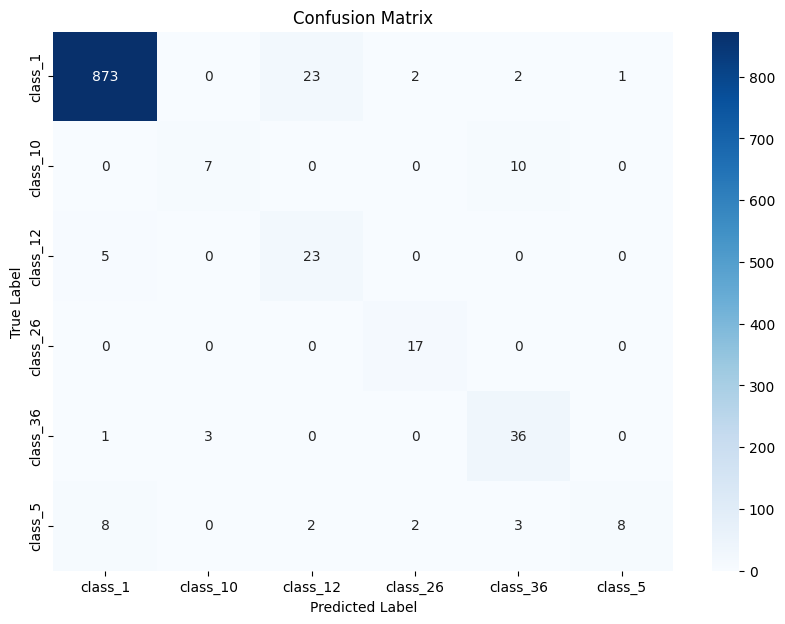

In [121]:
evaluate_model(model, test_loader, criterion, device)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def print_classification_metrics(y_true, y_pred, class_labels=None):
    """
    Prints confusion matrix, accuracy, precision, recall, and F1-score for a multiclass problem.

    :param y_true: Array of true labels
    :param y_pred: Array of predicted labels
    :param class_labels: List of class labels (optional, required for labeled confusion matrix)
    """
    # Compute metrics
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    # Print metrics
    print("Confusion Matrix:")
    print(cm)
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
y_true = np.array([0, 1, 2, 2, 0, 1, 2, 0, 1, 1])  # True labels
y_pred = np.array([0, 0, 2, 2, 0, 2, 1, 0, 1, 1])  # Predicted labels
class_labels = ['Class 0', 'Class 1', 'Class 2']

print_classification_metrics(y_true, y_pred, class_labels)